In [ ]:
pip install pyarrow


   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/25.1 MB 1.3 MB/s eta 0:00:19
   ---------------------------------------- 0.1/25.1 MB 1.4 MB/s eta 0:00:18
   ---------------------------------------- 0.2/25.1 MB 1.6 MB/s eta 0:00:17
   ---------------------------------------- 0.3/25.1 MB 1.7 MB/s eta 0:00:15
    --------------------------------------- 0.4/25.1 MB 1.7 MB/s eta 0:00:15
    --------------------------------------- 0.5/25.1 MB 1.7 MB/s eta 0:00:15
    --------------------------------------- 0.6/25.1 MB 1.7 MB/s eta 0:00:15
   - -------------------------------------- 0.7/25.1 MB 1.8 MB/s eta 0:00:14
   - -------------------------------------- 0.8/25.1 MB 1.9 MB/s eta 0:00:13
   - -------------------------------------- 0.9/25.1 MB 2.0 MB/s eta 0:00:13
   - -------------------------------------- 1.1/25.1 MB 2.0 MB/s eta 0:00:12
   - -------------------------------------- 1.2/25.1 MB 2.2 MB/s eta 0:00:12
   -- 

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils, callbacks
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics



In [ ]:
from scipy.stats import wilcoxon, friedmanchisquare
import seaborn as sns

In [ ]:
train_folder = 'D:/Sougata/Sign_lang_Custom_data/train'
all_data = []
for folder in os.listdir(train_folder):

    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

      label                                              path
0         A    D:/Sougata/Sign_lang_Custom_data/train\A\0.jpg
1         A    D:/Sougata/Sign_lang_Custom_data/train\A\1.jpg
2         A    D:/Sougata/Sign_lang_Custom_data/train\A\2.jpg
3         A    D:/Sougata/Sign_lang_Custom_data/train\A\3.jpg
4         A    D:/Sougata/Sign_lang_Custom_data/train\A\4.jpg
5         A    D:/Sougata/Sign_lang_Custom_data/train\A\5.jpg
6         A    D:/Sougata/Sign_lang_Custom_data/train\A\6.jpg
7         A    D:/Sougata/Sign_lang_Custom_data/train\A\7.jpg
8         A    D:/Sougata/Sign_lang_Custom_data/train\A\8.jpg
9         A    D:/Sougata/Sign_lang_Custom_data/train\A\9.jpg
10        A   D:/Sougata/Sign_lang_Custom_data/train\A\10.jpg
11        A   D:/Sougata/Sign_lang_Custom_data/train\A\11.jpg
12        A   D:/Sougata/Sign_lang_Custom_data/train\A\12.jpg
13        A   D:/Sougata/Sign_lang_Custom_data/train\A\13.jpg
14        A   D:/Sougata/Sign_lang_Custom_data/train\A\14.jpg
15      

In [ ]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

In [ ]:
img_width, img_height = 64, 64
batch_size = 64
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, horizontal_flip = True, vertical_flip=False)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=True
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=True
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)

holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 11537 validated image filenames belonging to 26 classes.
Found 2885 validated image filenames belonging to 26 classes.
Found 1603 validated image filenames belonging to 26 classes.


In [ ]:
# New Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define custom PolynomialConv2D layer
class PolynomialConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(PolynomialConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(PolynomialConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

model5 = Sequential()

model5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model5.add(BatchNormalization())  # Adding Batch Normalization for improved stability and performance
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model5.add(PolynomialConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

class InceptionModule(Layer):
    def __init__(self, filters=64, **kwargs):
        super(InceptionModule, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):

        self.conv1x1 = Conv2D(filters=self.filters, kernel_size=(1, 1), activation='relu', padding='same')
        self.conv3x3 = Conv2D(filters=self.filters, kernel_size=(3, 3), activation='relu', padding='same')
        self.conv5x5 = Conv2D(filters=self.filters, kernel_size=(5, 5), activation='relu', padding='same')
        self.pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')
        super(InceptionModule, self).build(input_shape)

    def call(self, x):

        tower_1 = self.conv1x1(x)

        tower_2 = self.conv1x1(x)
        tower_2 = self.conv3x3(tower_2)

        tower_3 = self.conv1x1(x)
        tower_3 = self.conv5x5(tower_3)

        tower_4 = self.pool(x)
        tower_4 = self.conv1x1(tower_4)


        output = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
        return output


model5.add(InceptionModule(filters=64))

model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Flatten())

model5.add(Reshape((1, -1)))

model5.add(LSTM(units=128, return_sequences=True))

# Define CASDPA mechanism (Context-Augmented Scaled Dot-Product Attention)
class CASDPA(Layer):
    def __init__(self, use_scale=True):
        super(CASDPA, self).__init__()
        self.use_scale = use_scale

    def build(self, input_shape):

        self.query_matrix = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                            initializer='glorot_uniform',
                                            trainable=True,
                                            name='query_matrix')


        self.global_avg_pool = GlobalAveragePooling1D()

    def call(self, inputs):

        context_vector = self.global_avg_pool(inputs)
        context_vector = tf.expand_dims(context_vector, axis=1)


        query = tf.matmul(inputs, self.query_matrix)
        value = inputs


        score = tf.matmul(query, value, transpose_b=True)


        if self.use_scale:
            d_k = tf.cast(tf.shape(value)[-1], tf.float32)
            score = score / tf.math.sqrt(d_k)


        attention_weights = tf.nn.softmax(score, axis=-1)


        context_augmented_attention = tf.matmul(attention_weights, value) + context_vector

        return context_augmented_attention


model5.add(CASDPA(use_scale=True))

model5.add(Flatten())

model5.add(Dense(units=no_of_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_4 (Batc (None, 62, 62, 32)        128       
 hNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling (None, 31, 31, 32)        0         
 2D)                                                            
                                                                 
 spectral_conv2d_3 (Spectral (None, 31, 31, 64)        18496     
 Conv2D)                                                        
                                                                 
 polynomial_conv2d_3 (Polyno (None, 31, 31, 64)        36928     
 mialConv2D)                                             

In [ ]:
# New Model with CNN + spectral CNN + polynomial CNN + inception Module + CASDPA mechanism
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define custom PolynomialConv2D layer
class PolynomialConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(PolynomialConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(PolynomialConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)


model5 = Sequential()

# Spatial Feature Extraction (CNN)
model5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model5.add(BatchNormalization())  # Adding Batch Normalization for improved stability and performance
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model5.add(PolynomialConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

class InceptionModule(Layer):
    def __init__(self, filters=64, **kwargs):
        super(InceptionModule, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.conv1x1 = Conv2D(filters=self.filters, kernel_size=(1, 1), activation='relu', padding='same')
        self.conv3x3 = Conv2D(filters=self.filters, kernel_size=(3, 3), activation='relu', padding='same')
        self.conv5x5 = Conv2D(filters=self.filters, kernel_size=(5, 5), activation='relu', padding='same')
        self.pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')
        super(InceptionModule, self).build(input_shape)

    def call(self, x):
        tower_1 = self.conv1x1(x)

        tower_2 = self.conv1x1(x)
        tower_2 = self.conv3x3(tower_2)

        tower_3 = self.conv1x1(x)
        tower_3 = self.conv5x5(tower_3)

        tower_4 = self.pool(x)
        tower_4 = self.conv1x1(tower_4)

        output = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
        return output

model5.add(InceptionModule(filters=64))

model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Flatten())

model5.add(Reshape((1, -1)))

model5.add(LSTM(units=128, return_sequences=True))

class CASDPA(Layer):
    def __init__(self, use_scale=True):
        super(CASDPA, self).__init__()
        self.use_scale = use_scale

    def build(self, input_shape):
        # Query matrix as a trainable weight
        self.query_matrix = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                            initializer='glorot_uniform',
                                            trainable=True,
                                            name='query_matrix')

        self.global_avg_pool = GlobalAveragePooling1D()

    def call(self, inputs):
        context_vector = self.global_avg_pool(inputs)
        context_vector = tf.expand_dims(context_vector, axis=1)  # Expand dimensions for proper broadcasting

        query = tf.matmul(inputs, self.query_matrix)
        value = inputs

        score = tf.matmul(query, value, transpose_b=True)

        if self.use_scale:
            d_k = tf.cast(tf.shape(value)[-1], tf.float32)
            score = score / tf.math.sqrt(d_k)

        attention_weights = tf.nn.softmax(score, axis=-1)

        context_augmented_attention = tf.matmul(attention_weights, value) + context_vector

        return context_augmented_attention

model5.add(CASDPA(use_scale=True))

model5.add(Flatten())

model5.add(Dense(units=no_of_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                                 patience=5, restore_best_weights=True)

classes = 26
epochs = 12
learning_rate = 0.0001

history5 = model5.fit(train_generator,
                      epochs=epochs,
                      verbose=1,
                      validation_data=validation_generator,
                      shuffle=True, callbacks=[earlystopping])


Epoch 1/12
181/181 [==============================] - 67s 1s/step - loss: 1.3080 - accuracy: 0.1544 - val_loss: 1.0297 - val_accuracy: 0.3832
Epoch 2/12
181/181 [==============================] - 69s 2s/step - loss: 0.8449 - accuracy: 0.5296 - val_loss: 0.7169 - val_accuracy: 0.6162
Epoch 3/12
181/181 [==============================] - 71s 3s/step - loss: 0.3868 - accuracy: 0.7970 - val_loss: 0.4976 - val_accuracy: 0.7208
Epoch 4/12
181/181 [==============================] - 73s 3s/step - loss: 0.1233 - accuracy: 0.9109 - val_loss: 0.4336 - val_accuracy: 0.7568
Epoch 5/12
181/181 [==============================] - 75s 4s/step - loss: 0.0543 - accuracy: 0.9656 - val_loss: 0.2493 - val_accuracy: 0.8783
Epoch 6/12
181/181 [==============================] - 77s 5s/step - loss: 0.0420 - accuracy: 0.9716 - val_loss: 0.1898 - val_accuracy: 0.9124
Epoch 7/12
181/181 [==============================] - 79s 5s/step - loss: 0.0374 - accuracy: 0.9686 - val_loss: 0.1611 - val_accuracy: 0.9410
Epoch 

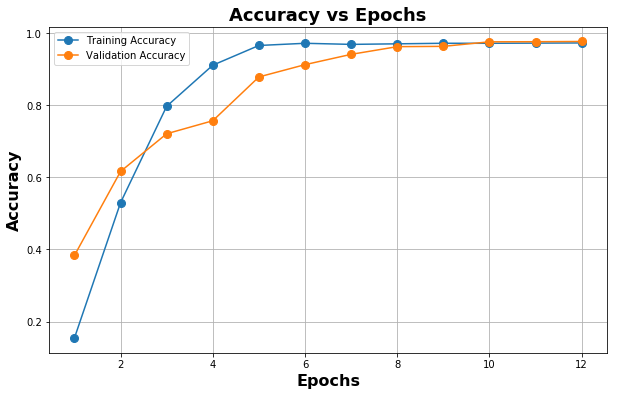

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'], '-o', label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], '-o', label='Validation Accuracy')
plt.title('Accuracy vs Epochs', fontsize=18, fontweight='bold')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

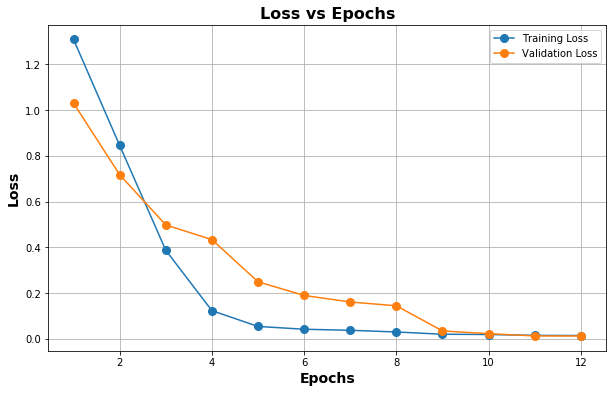

In [ ]:
# Loss graph
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'], '-o', label='Training Loss')
plt.plot(history5.history['val_loss'], '-o', label='Validation Loss')
plt.title('Loss vs Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# New Model with CNN + spectral CNN + polynomial CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define custom PolynomialConv2D layer
class PolynomialConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(PolynomialConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(PolynomialConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define the model
model3 = Sequential()

# Spatial Feature Extraction (CNN)
model3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model3.add(BatchNormalization())  # Adding Batch Normalization for improved stability and performance
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Add custom SpectralConv2D layer
model3.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Add custom PolynomialConv2D layer
model3.add(PolynomialConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model3.add(Flatten())  # Flatten the output of the attention layer

# Classification Layer
model3.add(Dense(units=no_of_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN (None, 62, 62, 32)        128       
 ormalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2D (None, 31, 31, 32)        0         
 )                                                              
                                                                 
 spectral_conv2d (SpectralCo (None, 31, 31, 64)        18496     
 nv2D)                                                          
                                                                 
 polynomial_conv2d (Polynomi (None, 31, 31, 64)        36928     
 alConv2D)                                                 

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                        patience=5, restore_best_weights = True)

classes = 26
epochs = 12
learning_rate = 0.0001

history3 = model3.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True, callbacks = [earlystopping])


Epoch 1/12
181/181 [==============================] - 67s 1s/step - loss: 1.9992 - accuracy: 0.1134 - val_loss: 2.9380 - val_accuracy: 0.4139
Epoch 2/12
181/181 [==============================] - 69s 2s/step - loss: 0.6460 - accuracy: 0.4825 - val_loss: 1.8729 - val_accuracy: 0.7703
Epoch 3/12
181/181 [==============================] - 71s 2s/step - loss: 0.3707 - accuracy: 0.7848 - val_loss: 1.6076 - val_accuracy: 0.8754
Epoch 4/12
181/181 [==============================] - 73s 3s/step - loss: 0.2395 - accuracy: 0.7833 - val_loss: 0.8752 - val_accuracy: 0.9206
Epoch 5/12
181/181 [==============================] - 75s 4s/step - loss: 0.1906 - accuracy: 0.8182 - val_loss: 0.5353 - val_accuracy: 0.9413
Epoch 6/12
181/181 [==============================] - 77s 4s/step - loss: 0.1423 - accuracy: 0.8699 - val_loss: 0.5279 - val_accuracy: 0.9571
Epoch 7/12
181/181 [==============================] - 79s 6s/step - loss: 0.1164 - accuracy: 0.8957 - val_loss: 0.4186 - val_accuracy: 0.9525
Epoch 

In [ ]:
# New Model with CNN + spectral CNN + polynomial CNN + inception Module
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define custom PolynomialConv2D layer
class PolynomialConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(PolynomialConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(PolynomialConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define the model
model4 = Sequential()

# Spatial Feature Extraction (CNN)
model4.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model4.add(BatchNormalization())  # Adding Batch Normalization for improved stability and performance
model4.add(MaxPooling2D(pool_size=(2, 2)))

# Add custom SpectralConv2D layer
model4.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Add custom PolynomialConv2D layer
model4.add(PolynomialConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Define an Inception module as a custom Keras layer
class InceptionModule(Layer):
    def __init__(self, filters=64, **kwargs):
        super(InceptionModule, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        # Define convolutional layers within the Inception module
        self.conv1x1 = Conv2D(filters=self.filters, kernel_size=(1, 1), activation='relu', padding='same')
        self.conv3x3 = Conv2D(filters=self.filters, kernel_size=(3, 3), activation='relu', padding='same')
        self.conv5x5 = Conv2D(filters=self.filters, kernel_size=(5, 5), activation='relu', padding='same')
        self.pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')
        super(InceptionModule, self).build(input_shape)

    def call(self, x):
        # Define the different towers of the Inception module
        tower_1 = self.conv1x1(x)

        tower_2 = self.conv1x1(x)
        tower_2 = self.conv3x3(tower_2)

        tower_3 = self.conv1x1(x)
        tower_3 = self.conv5x5(tower_3)

        tower_4 = self.pool(x)
        tower_4 = self.conv1x1(tower_4)

        # Concatenate the outputs of the towers to form the final output
        output = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
        return output

# Add the Inception module
model4.add(InceptionModule(filters=64))

model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Flatten())  # Flatten the output of the attention layer

# Classification Layer
model4.add(Dense(units=no_of_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model4.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_5 (Batc (None, 62, 62, 32)        128       
 hNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling (None, 31, 31, 32)        0         
 2D)                                                            
                                                                 
 spectral_conv2d_4 (Spectral (None, 31, 31, 64)        18496     
 Conv2D)                                                        
                                                                 
 polynomial_conv2d_3 (Polyno (None, 31, 31, 64)        36928     
 mialConv2D)                                             

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                        patience=5, restore_best_weights = True)

classes = 26
epochs = 12
learning_rate = 0.0001

history4 = model4.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True, callbacks = [earlystopping])



Epoch 1/12
181/181 [==============================] - 67s 1s/step - loss: 2.0414 - accuracy: 0.1195 - val_loss: 2.9467 - val_accuracy: 0.4222
Epoch 2/12
181/181 [==============================] - 69s 2s/step - loss: 0.5718 - accuracy: 0.4689 - val_loss: 1.6373 - val_accuracy: 0.8290
Epoch 3/12
181/181 [==============================] - 71s 3s/step - loss: 0.4880 - accuracy: 0.7559 - val_loss: 0.7899 - val_accuracy: 0.9132
Epoch 4/12
181/181 [==============================] - 73s 3s/step - loss: 0.4198 - accuracy: 0.8759 - val_loss: 0.7489 - val_accuracy: 0.9316
Epoch 5/12
181/181 [==============================] - 75s 4s/step - loss: 0.3492 - accuracy: 0.8638 - val_loss: 0.6350 - val_accuracy: 0.9594
Epoch 6/12
181/181 [==============================] - 77s 4s/step - loss: 0.3223 - accuracy: 0.9443 - val_loss: 0.5588 - val_accuracy: 0.9632
Epoch 7/12
181/181 [==============================] - 79s 5s/step - loss: 0.2948 - accuracy: 0.9458 - val_loss: 0.4737 - val_accuracy: 0.9595
Epoch 

In [3]:
# New Model with CNN + spectral CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define the model
model2 = Sequential()

# Spatial Feature Extraction (CNN)
model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model2.add(BatchNormalization())  # Adding Batch Normalization for improved stability and performance
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Add custom SpectralConv2D layer
model2.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model2.add(Flatten())  # Flatten the output of the attention layer

# Classification Layer
model2.add(Dense(units=no_of_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model2.summary())


earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                        patience=5, restore_best_weights = True)

classes = 26
epochs = 12
learning_rate = 0.0001

history2 = model2.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True, callbacks = [earlystopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_2 (Batc (None, 62, 62, 32)        128       
 hNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPooling (None, 31, 31, 32)        0         
 2D)                                                            
                                                                 
 spectral_conv2d_1 (Spectral (None, 31, 31, 64)        18496     
 Conv2D)                                                        
                                                                 
 flatten_3 (Flatten)         (None, 61504)             0         
                                                         

## Apply Wilcoxon Signed-Rank Test

In [ ]:
from scipy.stats import wilcoxon
import numpy as np

# Assuming 'holdout_generator' contains the test data
y_true = holdout_generator.classes  # True labels

# Generate predictions from model1 (assuming model1 has been trained similarly)
y_pred_probs_model1 = model4.predict(holdout_generator)
y_pred_model1 = np.argmax(y_pred_probs_model1, axis=1)  # Predicted labels for model1

# Generate predictions from model5
y_pred_probs_model5 = model5.predict(holdout_generator)
y_pred_model5 = np.argmax(y_pred_probs_model5, axis=1)  # Predicted labels for model5

# Wilcoxon signed-rank test between model1 and model5 predictions
statistic, p_value = wilcoxon(y_pred_model1, y_pred_model5)

# Calculate Z-statistic (since Wilcoxon produces W-statistic)
z_statistic = (statistic - (len(y_pred_model1) * (len(y_pred_model1) + 1)) / 4) / np.sqrt((len(y_pred_model1) * (len(y_pred_model1) + 1) * (2 * len(y_pred_model1) + 1)) / 24)

# Calculate Effect Size (r), where r = Z / sqrt(n)
effect_size = z_statistic / np.sqrt(len(y_pred_model1))

# Print results
print(f"Wilcoxon p-value: {p_value:.3f}")
print(f"Z-Statistic: {z_statistic:.2f}")
print(f"Effect Size: {effect_size:.2f}")


Wilcoxon p-value: 0.008
Z-Statistic: -2.62
Effect Size: 0.52


## Apply Friedman Test

In [ ]:
from scipy.stats import friedmanchisquare, rankdata
import numpy as np

y_true = holdout_generator.classes

y_pred_probs_model3 = model2.predict(holdout_generator)
y_pred_model3 = np.argmax(y_pred_probs_model3, axis=1)

y_pred_probs_model2 = model3.predict(holdout_generator)
y_pred_model2 = np.argmax(y_pred_probs_model2, axis=1)

y_pred_probs_model1 = model4.predict(holdout_generator)
y_pred_model1 = np.argmax(y_pred_probs_model1, axis=1)

y_pred_probs_model5 = model5.predict(holdout_generator)
y_pred_model5 = np.argmax(y_pred_probs_model5, axis=1)


# Friedman Test
friedman_stat, friedman_p_value = friedmanchisquare(y_pred_model5, y_pred_model1, y_pred_model2, y_pred_model3)

# Print Chi-Square Statistic (χ²)
print(f"Chi-Square Statistic (χ²): {friedman_stat:.2f}")


k = 4  # Number of models
df = k - 1  # Degrees of Freedom (df)
print(f"Degrees of Freedom (df): {df}")

# Calculate Sum of Squares (SS)
data = np.array([y_pred_model5, y_pred_model1, y_pred_model2, y_pred_model3]).T
ranks = np.apply_along_axis(rankdata, 1, data)
mean_ranks = np.mean(ranks, axis=0)
overall_mean_rank = np.mean(mean_ranks)

N = len(y_true)

SS_total = N * np.sum((mean_ranks - overall_mean_rank) ** 2)
print(f"Sum of Squares (SS): {SS_total:.2f}")

MS = SS_total / df
print(f"Mean Square (MS): {MS:.3f}")

print(f"p-value: {friedman_p_value:.3f}")


Chi-Square Statistic (χ²): 10.92
Degrees of Freedom (df): 3
Sum of Squares (SS): 14.95
Mean Square (MS): 4.983
p-value: 0.0138
